In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle
import plotly.express as px

In [3]:
train_data = pd.read_excel('Flight Dataset/Data_Train.xlsx')
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Destination Analysis

In [4]:
train_data['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

**Delhi** and **New Delhi** are basically the same place. Let's join them together first.

In [5]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)

In [6]:
destination_counts = train_data['Destination'].value_counts(); destination_counts

Cochin       4537
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [7]:
#converting destination_counts to pandas dataframe to use for plotting
destination_counts_df = pd.DataFrame(destination_counts,)
destination_counts_df['Destination_pct'] =  round((destination_counts_df['Destination'] / destination_counts_df['Destination'].sum()) * 100, 2)


In [8]:
destination_counts_df

,Destination,Destination_pct
Cochin,4537,42.47
Banglore,2871,26.87
Delhi,2197,20.57
Hyderabad,697,6.52
Kolkata,381,3.57


In [9]:
fig = px.bar(destination_counts_df, y='Destination_pct', labels={
                     "index": "Destination",
                     "Destination_pct": "Count(%)", 
                 })
fig.show()

Maximum people are going to Cochin followed by Bangalore and then Delhi in our dataset. So, the top 3 destinations are:
- Cochin(42%)
- Bangalore(27%)
- Delhi(20%)

Kolkata receives the least traffic.

# Source Analysis

In [10]:
source_counts =  pd.DataFrame(train_data['Source'].value_counts()); 
source_counts['Source_pct'] = (source_counts['Source']/source_counts['Source'].sum())*100.0
source_counts

,Source,Source_pct
Delhi,4537,42.469344
Kolkata,2871,26.874473
Banglore,2197,20.565384
Mumbai,697,6.524385
Chennai,381,3.566414


In [11]:
fig = px.bar(source_counts, y='Source_pct', labels={
                     "index": "Source",
                     "Source_pct": "Count(%)", 
                 }, )
fig.update_traces(marker_color='green')
fig.show()

A plurality of flight passengers fly from Delhi, followed by Kolkata and Bangalore respectively. A lot more folks fly from Kolkata than to Kolkata. Delhi and Bangalore has comparatively high inbound and outbound traffic. 

# Checking info of the train data

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


Only 1 null value for each of Route and Total_Stops columns. 

In [13]:
train_data.dropna(axis=0, how='any', inplace=True)
train_data.shape

(10682, 11)

# Processing Time Based Columns

## Extract day and month columns from Date_of_journey column

In [14]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


we will drop the Date of the journey column.

## Extracting hours and minutes from departure and arrival time

In [15]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True) #drop the departure time column
train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True) #drop the arrival time column
train_data.head() 

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


## Dropping the Duration column and extracting important info(Hour and Minute) from it

In [16]:
duration = list(train_data['Duration'])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]
duration_hour = []
duration_min = []
for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [17]:
duration_hour_df= pd.DataFrame(train_data['Duration_hours'].value_counts())
duration_hour_df['Duration_hours_pct'] = (duration_hour_df['Duration_hours']/duration_hour_df['Duration_hours'].sum())*100.0
duration_hour_df.reset_index(inplace=True)
duration_hour_df.rename(columns={'index': 'Hour'},inplace=True)
duration_hour_df[:5]

,Hour,Duration_hours,Duration_hours_pct
0,2,2402,22.486426
1,1,621,5.813518
2,3,501,4.690133
3,7,487,4.559071
4,5,481,4.502902


In [18]:
duration_hour_df['Hour'].describe()

count    44.000000
mean     21.590909
std      13.013978
min       0.000000
25%      10.750000
50%      21.500000
75%      32.250000
max      47.000000
Name: Hour, dtype: float64

In [19]:
fig = px.bar(duration_hour_df,x='Hour', y='Duration_hours_pct', labels={
                     "Hour": "Duration(hr)",
                     "Duration_hours_pct": "Count(%)", 
                 })
fig.show()

About 22%( above 1/5) of the flights are between 2-3 hours. About 6% of the flights are between 1-2 hours. The rest of the durations are below 5%. So, we have a wide range of flight durations from 0 to 47 hours

# Analyzing and Changing Categorical Columns

## Airline

### Plotting Airline vs Price

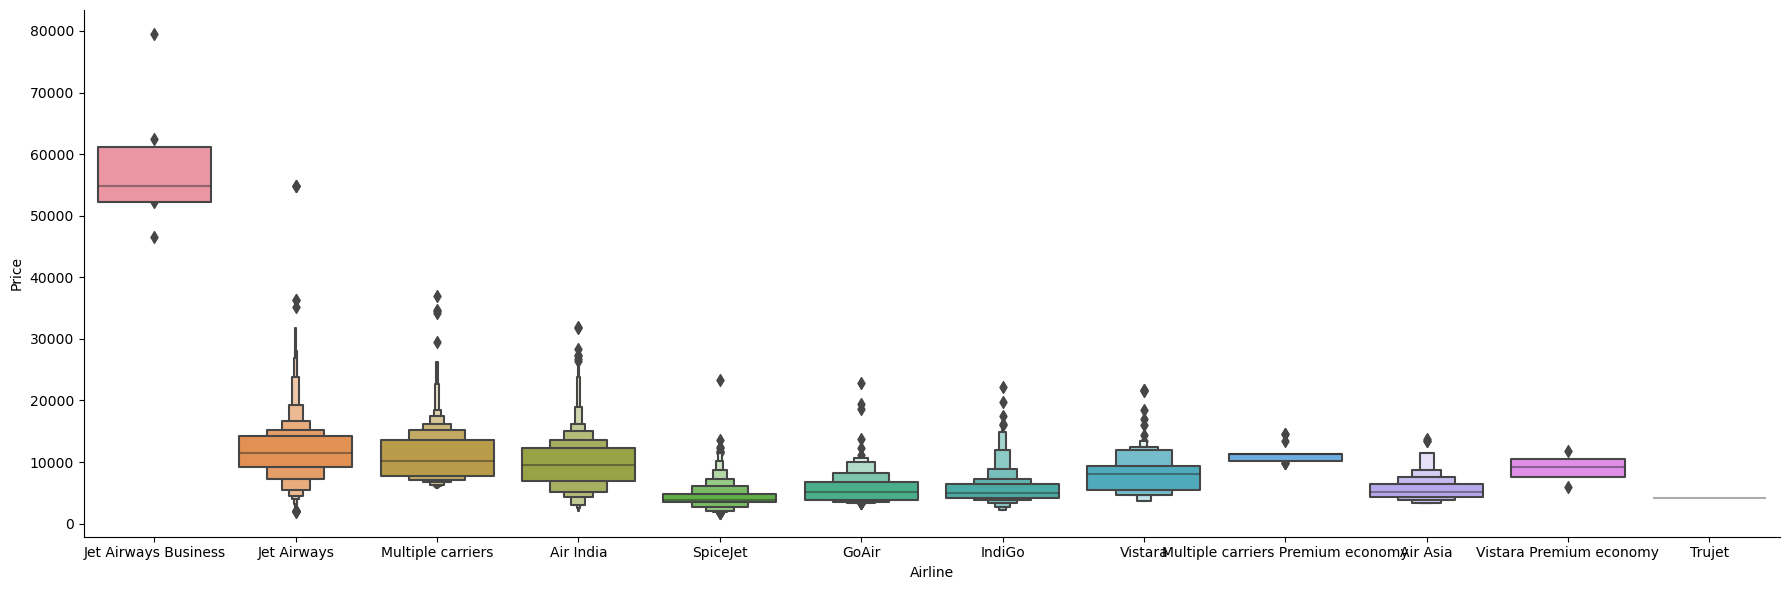

In [20]:
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

From the plot, we can infer that Jet Airways business is the costliest airways while Spicejet is comparatively cheaper.

### Create dummy columns for Airline column

In [21]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)
airline.head(5)

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


As Airline is a categorical column, so we will make dummy columns out of it.

## Source

### Plotting Source vs Price

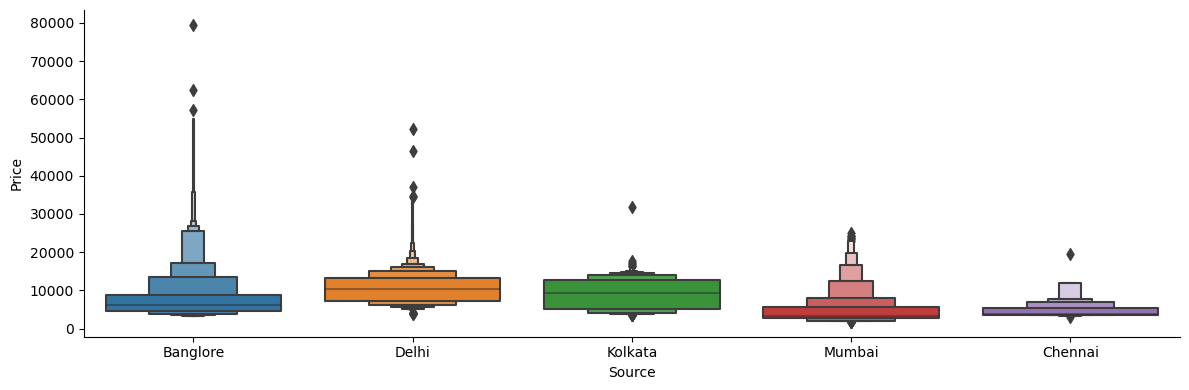

In [22]:
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

The plot says if you're going from Bangalore to anywhere you have to pay the highest amount of money

### Create dummy columns out of the Source column

In [23]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


As Source is a categorical column, so we will make dummy columns out of it.

## Destination

### Plotting Destination vs Price

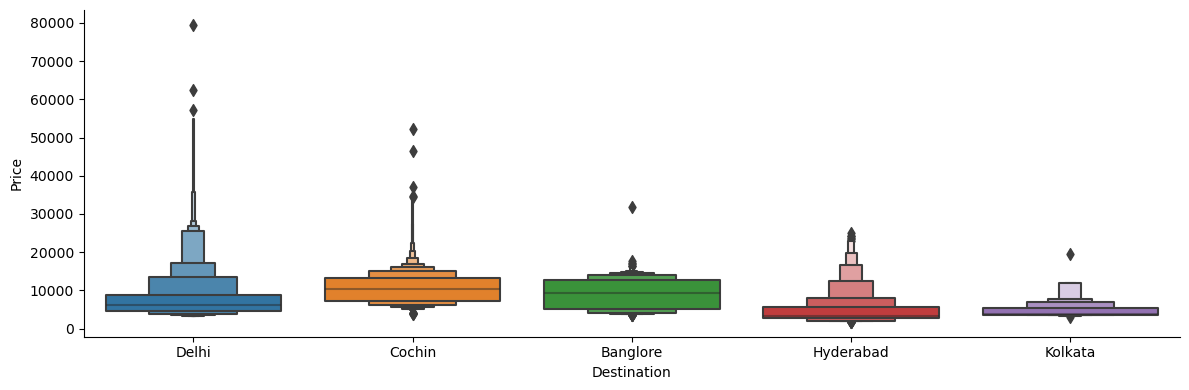

In [24]:
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

The plot says if you are going to Delhi from anywhere, you have to pay the highest amount of money.

### Create dummy columns out of the Destination column

In [25]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0



As Destination is also a categorical column, so we will make dummy columns out of it.

## Total_Stops

In [26]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1) #we don't need these cols for model training

In [27]:
stops_df = pd.DataFrame(train_data['Total_Stops'].value_counts())
fig = px.bar(stops_df, y='Total_Stops', labels={
                     "index": "Number of Stops",
                     "Total_Stops": "Count", 
                 })
fig.show()

Most flights have 1 stop. However, there are quite a number of flights that have no stops in the middle

In [28]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


## Combining the Newly Created DFs with the Training Data

In [29]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10682, 11)
(10682, 4)
(10682, 4)
(10682, 13)


- All these 4 data frames have the same number of rows, which means we did everything correctly.
- And now we can join them.


In [30]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


# Correlations between Columns

/tmp/ipykernel_6016/1098957341.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

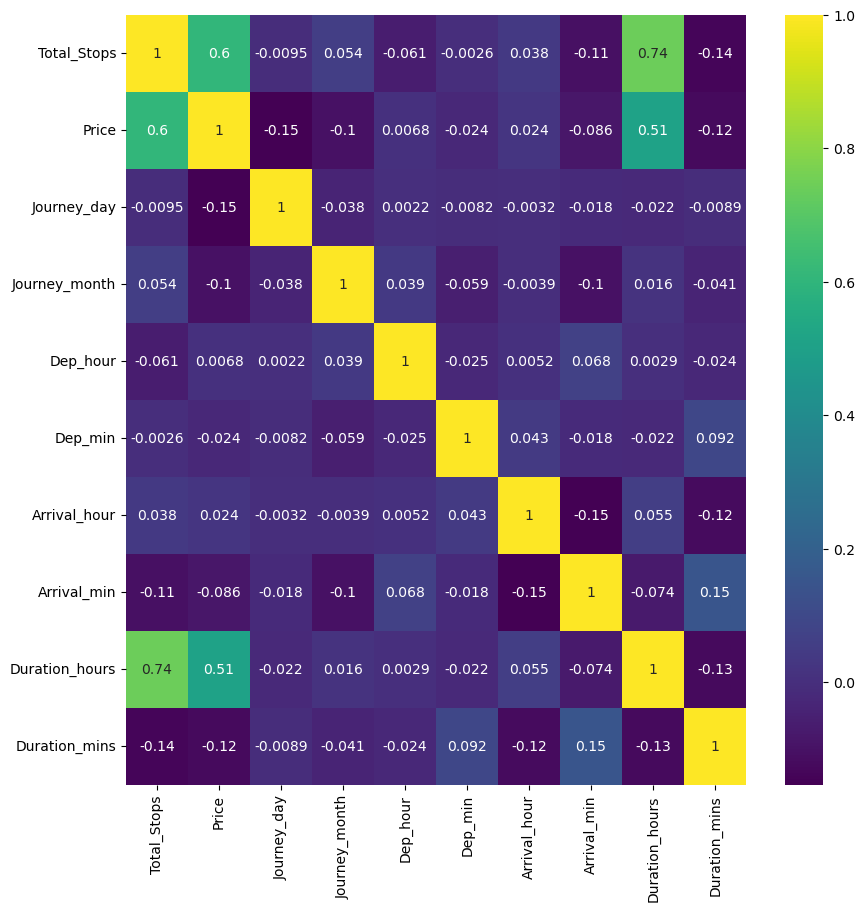

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

- We can see that Total_stops is highly correlated with Duration_hours which is very obvious. If the no. of stops would increase, the duration hours of the flight will also increase.
- Also, price is highly correlated with total stops because if stops would increase that would also require a high quantity of fuel, and that would increase the price.

# Training Models

In [32]:
X = data_train.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0



- Here we are taking our training data.
- We have taken all the columns except the Price column, which is our target column.


In [33]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

## Feature Importance from ExtraTreeRegressor

In [34]:
reg = ExtraTreesRegressor()
reg.fit(X,y)
print(reg.feature_importances_)

[2.35138993e-01 1.42837578e-01 5.79108667e-02 2.42609004e-02
 2.15876495e-02 2.77796624e-02 1.85113727e-02 1.31807907e-01
 1.86094377e-02 9.01067390e-03 1.73676254e-03 1.82640502e-02
 1.34709583e-01 6.70620737e-02 1.86381057e-02 8.21867315e-04
 5.52096800e-03 1.17682649e-04 4.61030534e-03 6.33891036e-05
 6.84374045e-04 1.06268420e-02 4.77027148e-03 8.13036665e-03
 8.35459177e-03 1.88521923e-02 8.88748890e-03 6.94043644e-04]


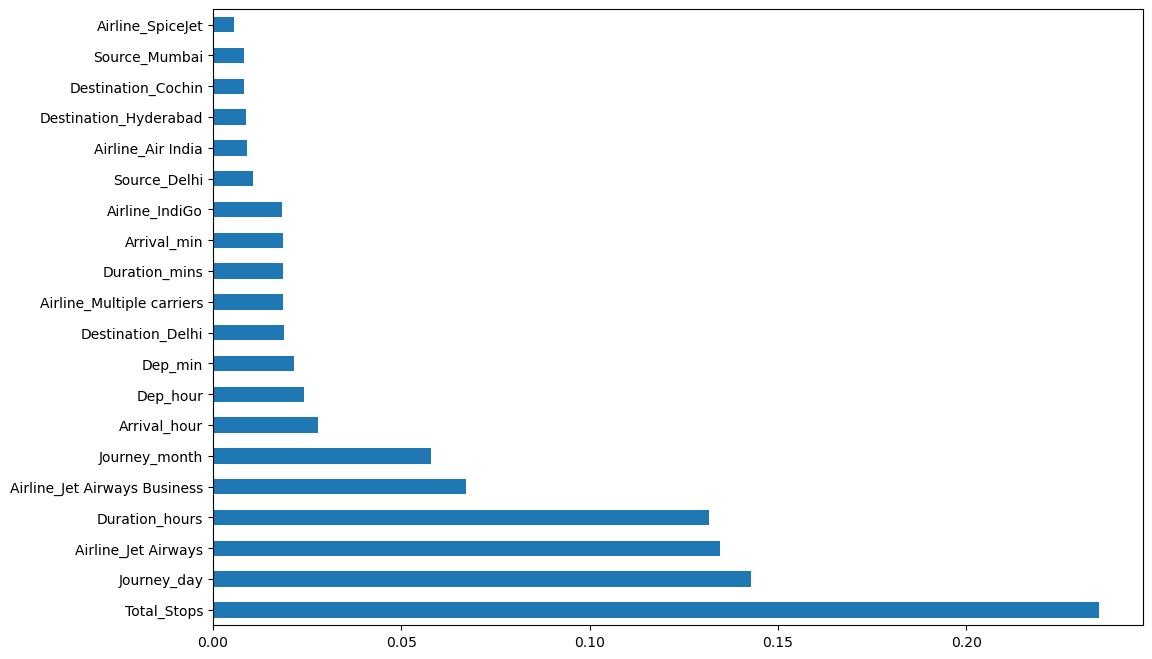

In [35]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


- Total_stops is the feature with the highest feature importance in deciding the Price as we have also seen above.
- After that Journey Day also plays a big role in deciding the Price. Prices are generally higher on weekends.

## Random Forest Regressor 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

20% of the data is reserved for testing.

In [37]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
n_estimators

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

Here we are using RandomizedSearchCV which just randomly tries out combinations and sees which one is the best out of them.

In [39]:
#Checking the best parameters we got using Randomized Search CV
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

## Taking Predictions

In [40]:
# Flight Price Prediction
prediction = rf_random.predict(X_test)

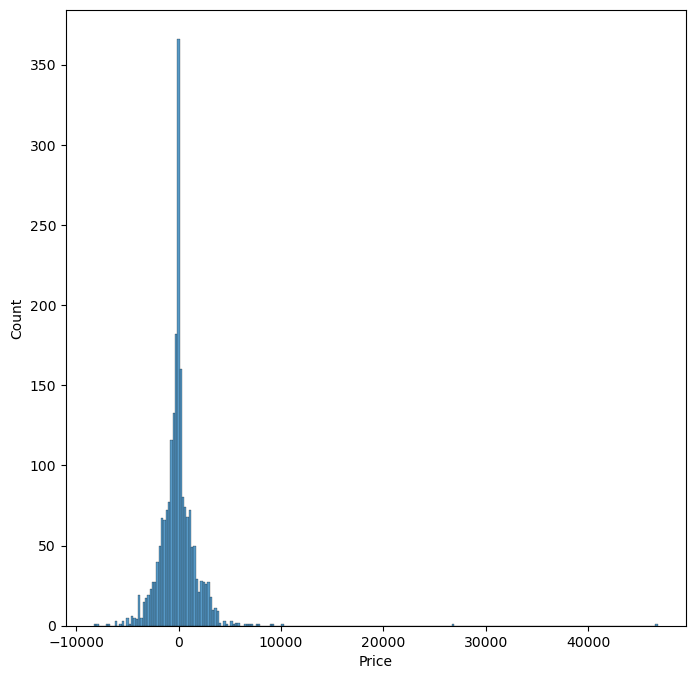

In [41]:
#Plotting the residuals
plt.figure(figsize = (8,8))
sns.histplot(y_test-prediction)
plt.show()

As we can see that most of the residuals are 0, which means our model is generalizing well.

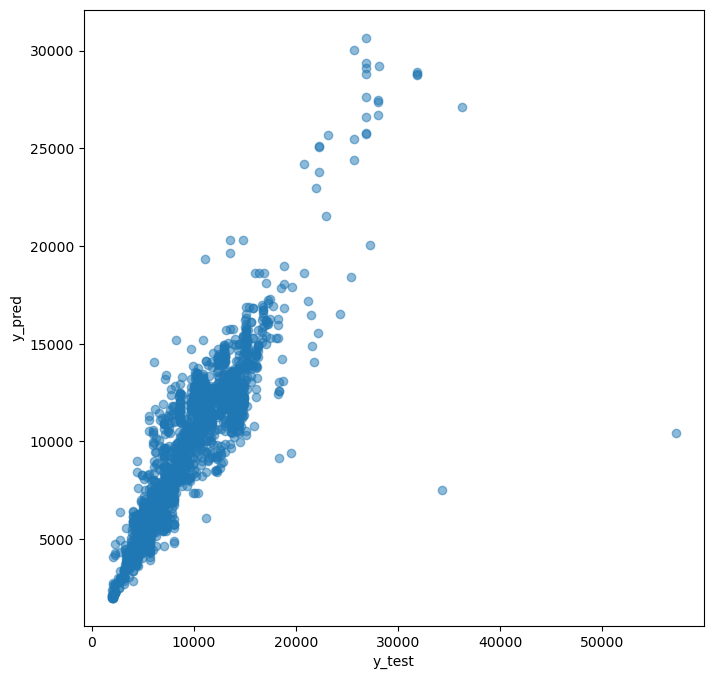

In [42]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

- Simply plotting our predictions vs the true values.
- Ideally, it should be a straight line.


In [43]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.80880667420437


## Saving Model

In [44]:
file = open('model/flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)